# COVID-19 Analyses

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, random
import json, warnings
import scipy.stats as st
import pystan

In [2]:
%matplotlib inline

### Introduction
 - This notebook presents some analyses on the Covid19 public case dataset provided by Johns Hopkins / NIH
 - This dataset available on AWS as a public dataset covid-19. Currently this is refreshed daily.
 - All are encouraged to sign up for the AWS subscription for this data (currently free for 3 years). 
 - I download and use the latest extract csv file from AWS in this notebook. 
 - Contact me at ramesh.k.raghunathan@gmail for discussions or clarifications. 

### Get some reference data first
     - google and get this from the web, multiple sources host such information
     - ISO2 2 digit Country code and name lookup
     - Populations of countries per ISO2 code

In [3]:
iso2_df = pd.read_csv('iso2_codes.csv')
iso2_df = iso2_df.set_index('Code')

with open('iso2_population.json', 'r') as f:
    pop_data = json.load(f)

iso2_pop_df = pd.DataFrame.from_dict(pop_data, orient='index', columns=['Population'])
iso2_pop_df.index.name='Code'
ref_df = iso2_df.join(iso2_pop_df)

print("Countries with population missing:")
print(print(ref_df[ref_df['Population'].isnull()]))
ref_df = ref_df.dropna(subset=['Population'])

iso2_continents_df = pd.read_csv('iso2_continents.csv', header=None, na_filter = False)
iso2_continents_df.columns=['Code','Continent']
iso2_continents_df = iso2_continents_df.set_index('Code')

ref_df = ref_df.join(iso2_continents_df) 
print("Countries with continent missing:")
print(print(ref_df[ref_df['Continent'].isnull()]))
ref_df = ref_df.dropna(subset=['Continent'])
print("Total Countries in reference data -->", len(ref_df))
ref_df[ref_df.index == 'US']

Countries with population missing:
         Name Population
Code                    
NaN   Namibia        NaN
None
Countries with continent missing:
                                  Name Population Continent
Code                                                       
BQ    Bonaire, Sint Eustatius and Saba      18012       NaN
CW                             Curaçao     141766       NaN
SX           Sint Maarten (Dutch part)      37429       NaN
SS                         South Sudan    8260490       NaN
None
Total Countries in reference data --> 244


,Name,Population,Continent
Code,,,
US,United States,310232863,NA


### Get the latest data from AWS
    Data in this version of the notebook:
        Link --> https://us-west-2.console.aws.amazon.com/dataexchange/home?region=us-west-2#/entitled-data-sets/48202caf8891b4bca4025ab2d2a42c15
        Revision ID --> 943efed95f2c474f005b1786c7d91353
        Updated on --> Apr 22, 2020, 8:22 PM CDT
        csv file --> published_1588130808_COVID-19 Cases.csv

In [4]:
cov19_raw_df = pd.read_csv('published_1588130808_COVID-19 Cases.csv', low_memory=False)
print(cov19_raw_df.Case_Type.unique())
cov19_raw_df[cov19_raw_df['iso2'] == 'US'].head(1)

#print(len(cov19_raw_df[cov19_raw_df['iso2'] == 'US']['Province_State'].unique()))
#sorted(cov19_raw_df[cov19_raw_df['iso2'] == 'US']['Province_State'].unique())

['Confirmed' 'Deaths']


,Case_Type,People_Total_Tested_Count,Cases,Difference,Date,Combined_Key,Country_Region,Province_State,Admin2,iso2,iso3,FIPS,Lat,Long,Population_Count,People_Hospitalized_Cumulative_Count,Data_Source,Prep_Flow_Runtime
50215,Deaths,NaN,0,0,4/19/2020,"Jackson, Kansas, US",US,Kansas,Jackson,US,USA,20085.0,39.416734,-95.793568,13171.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,4/28/2020 11:20:35 PM


### Observations Regarding Data
 - Data is only available for two case_types -- Confirmed and Deaths;
 - Admin2 in the US incudes county information for more fine grained analyses than just state/region;
 - There is widespread information, visualizations, and ad-hoc analyses available on this data;
 - Implications of this data for public policy and decision making is controversial with open disagreement:
      - Countries have employed different policy responses ranging from "extreme isolation" (e.g. China) vs. "herd immunity" in others;
      - Within countries (e.g. the US) regions/states have employed different strategies for testing and control;
      - Strategies are changing over time (herd immunity abandoned and replaced by curve flattening and vice versa).
 - Data quality (with respect to disease modelinbg) is a serious challenge:
      - It is an open secret that case counts (specifically infected people counts) are severely underestimated;
      - Testing started later, today testing is still strongly biased to people who are already at risk or exposed. 
      - Recent surveys hint at higher case counts than previously assumed based on new antibody blood tests;
      - Conclusions based on such surveys are premature and likely flawed (google the recent Stanford study);
      - However, regardless of the actual statistical accuracy, the data does reveal the limitations of relying on historical measured test cases for modeling. 

### Hypotheses Regarding Data
 - Avoid relying on case counts entirely; instead focus on death counts.
 - Death rates attributable to Covid19, while still underestimated to some degree, are currently the only reliable indicator of disease penetration in a population.
 - Deaths lag exposure and incidence substantially, anecdotal survey of popular media suggests approximately 1 month lag from infection to mortality.
 - This paper will explore this hypothesis in a principled way.
 - How far can we go by just relying on mortality counts? 

### Basic Data Visualization
    Counts, cumulative & daily mortality counts across countries, regions, counties

In [5]:
#Fix date column data type
print(cov19_raw_df['Date'].dtype) 
cov19_raw_df['Date'] = pd.to_datetime(cov19_raw_df['Date'])
print(cov19_raw_df['Date'].dtype) 

#Get grouped data across all countries
all_deaths_df_grouped = cov19_raw_df.loc[ (cov19_raw_df['Case_Type'] == 'Deaths')][['Date','Cases']].groupby('Date').sum()

#United States Data
us_deaths_df_grouped = cov19_raw_df.loc[ (cov19_raw_df['Case_Type'] == 'Deaths') & (cov19_raw_df['iso2'] == 'US') ][['Date','Cases']].groupby('Date').sum()
#Italy Data
it_deaths_df_grouped = cov19_raw_df.loc[ (cov19_raw_df['Case_Type'] == 'Deaths') & (cov19_raw_df['iso2'] == 'IT') ][['Date','Cases']].groupby('Date').sum()

# approximately 3 months worth of data in this extract
len(us_deaths_df_grouped.index),len(us_deaths_df_grouped['Cases']) 

object
datetime64[ns]


(98, 98)

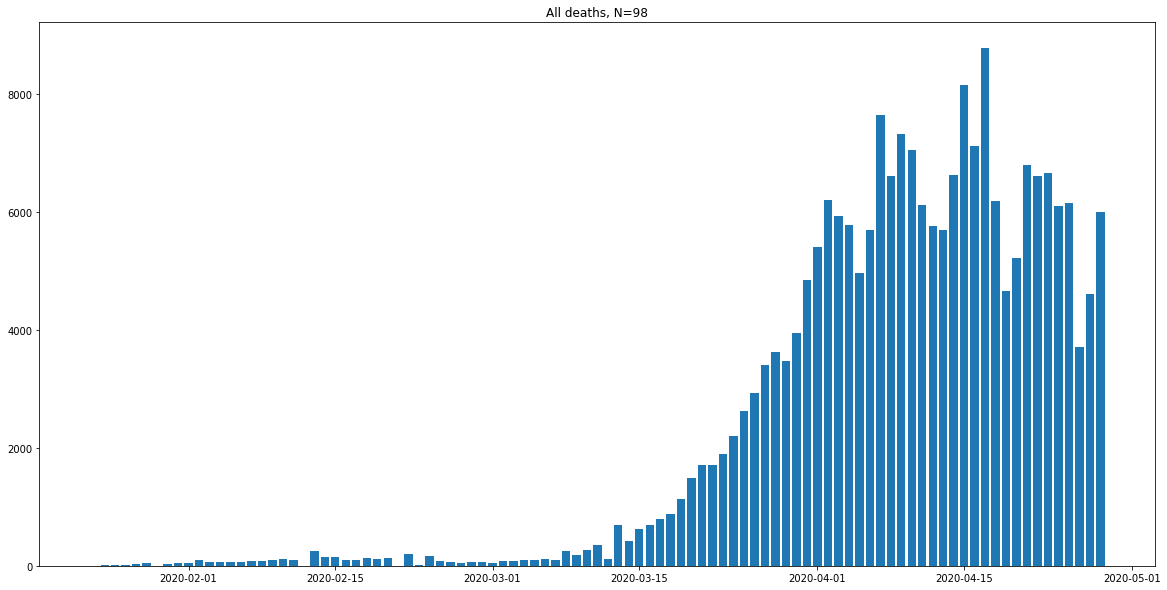

In [6]:
plt.figure(figsize=(20,10))
plt.bar(all_deaths_df_grouped.index, all_deaths_df_grouped['Cases'].diff()) 
plt.title("All deaths, N="+str(len(all_deaths_df_grouped.index)))
plt.show()

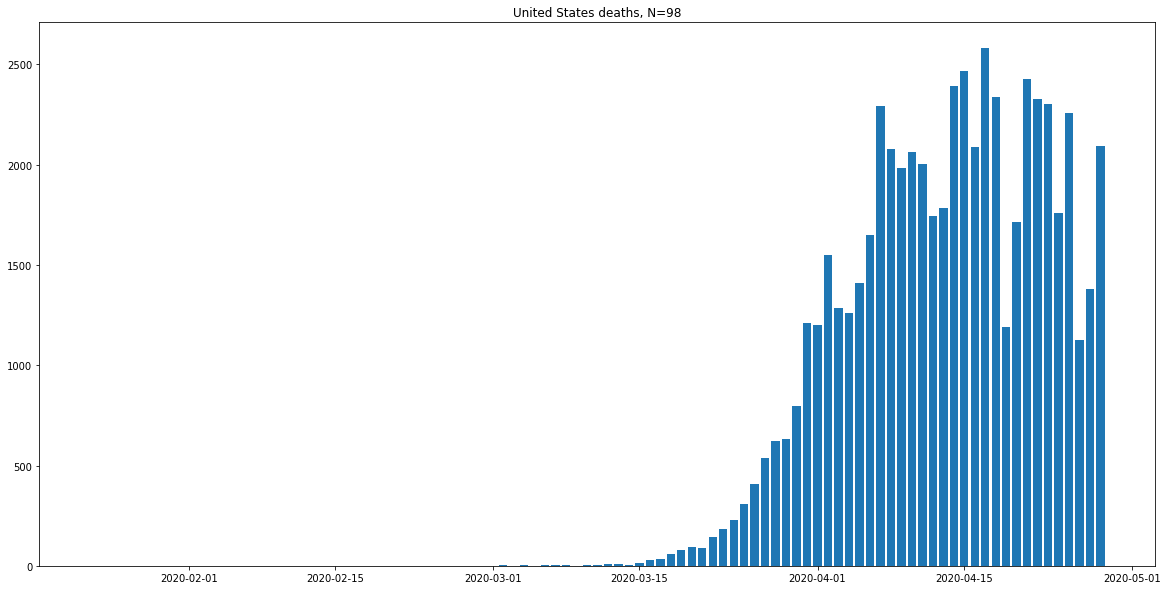

In [7]:
#cases are cumulative so need to diff them to get row differences (by default axis = 0)
plt.figure(figsize=(20,10))
plt.bar(us_deaths_df_grouped.index, us_deaths_df_grouped['Cases'].diff()) 
plt.title("United States deaths, N="+str(len(all_deaths_df_grouped.index)))
plt.show()

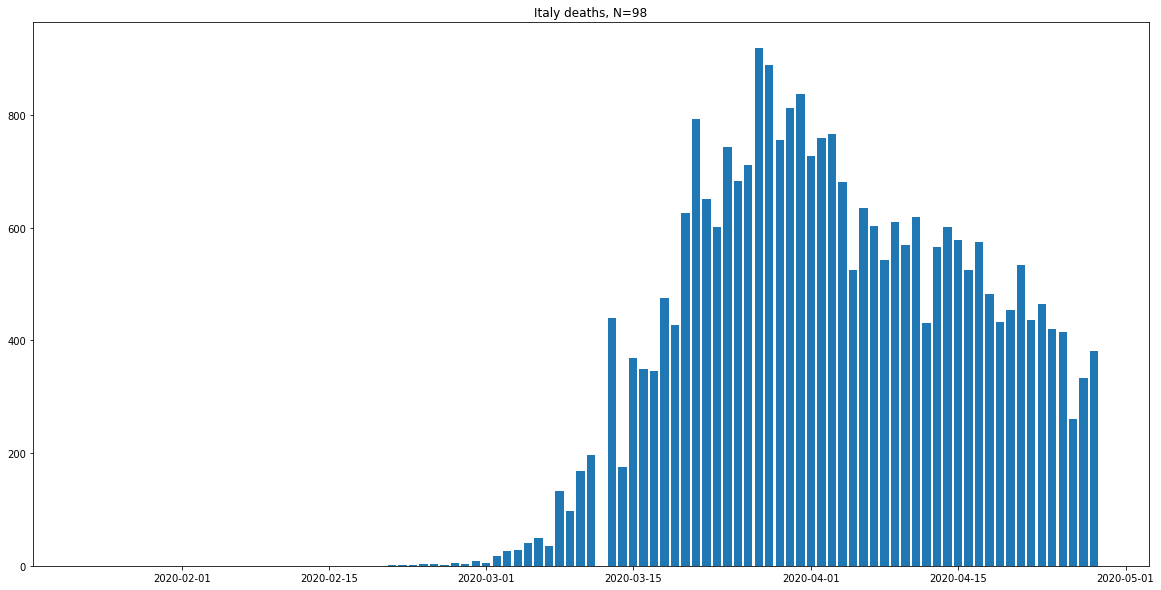

In [8]:
plt.figure(figsize=(20,10))
plt.bar(it_deaths_df_grouped.index, it_deaths_df_grouped['Cases'].diff()) 
plt.title("Italy deaths, N="+str(len(all_deaths_df_grouped.index)))
plt.show()

### Analysis 1 -- Duration relationship between first mortality and the peak 
    - First look at the duration between first recorded mortality and the peak 
    - Compare across countries
    - Refine across regions
    - Fit a model and compare to fitted data 
    - Predict for counties and compare to data 
        - Will predictions of peak mortality be useful for policy / planning e.g. ventilator acquisitions?

In [9]:
def get_peak_mortality_durations(df):
    output = {}
    for cntry in df['iso2'].unique():
        data = df.loc[ (df['Case_Type'] == 'Deaths') & (df['iso2'] == cntry)]
        data = data.sort_values(by='Date')
        data = data[['Date','Cases']].groupby('Date').sum()
        raw_cnt = len(data)
        if len(data[data['Cases'].gt(0)]) > 0:
            min_index = data[data['Cases'].gt(0)].index[0]
            if len(data) > 1:
                max_index = data.diff()['Cases'].idxmax()
                dur = max_index - min_index
                if dur.days > 0:
                    output[cntry] = dur.days
    return output

all_cntry_durations = get_peak_mortality_durations(cov19_raw_df)

In [10]:
duration_data = []
for c in all_cntry_durations.keys():
    if c in ref_df.index:
        duration_data.append( [c,all_cntry_durations[c]] + list(ref_df.loc[ c, : ].values) )

duration_df = pd.DataFrame(duration_data, columns=['Code','Dur','Name','Pop','Cont'])
duration_df = duration_df.set_index('Code')
#duration_df = duration_df.reset_index()
duration_df.head()

,Dur,Name,Pop,Cont
Code,,,,
CH,30,Switzerland,7581000,EU
CY,2,Cyprus,1102677,AS
JM,13,Jamaica,2847232,NA
PL,43,Poland,38500000,EU
CA,38,Canada,33679000,NA


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


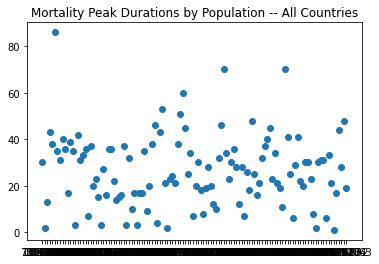

In [11]:
plt.plot(duration_df['Pop'], duration_df['Dur'],'o') 
plt.title("Mortality Peak Durations by Population -- All Countries")
plt.show()

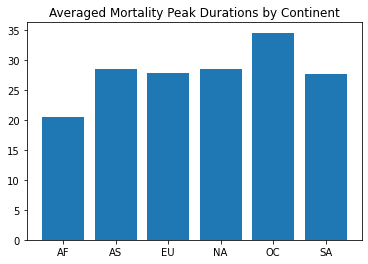

In [12]:
cont_dur = duration_df[['Dur','Cont']].groupby('Cont').mean()
cont_dur.head()
plt.bar(cont_dur.index, cont_dur.Dur)
plt.title("Averaged Mortality Peak Durations by Continent")
plt.show()

In [13]:
duration_df.head()

,Dur,Name,Pop,Cont
Code,,,,
CH,30,Switzerland,7581000,EU
CY,2,Cyprus,1102677,AS
JM,13,Jamaica,2847232,NA
PL,43,Poland,38500000,EU
CA,38,Canada,33679000,NA


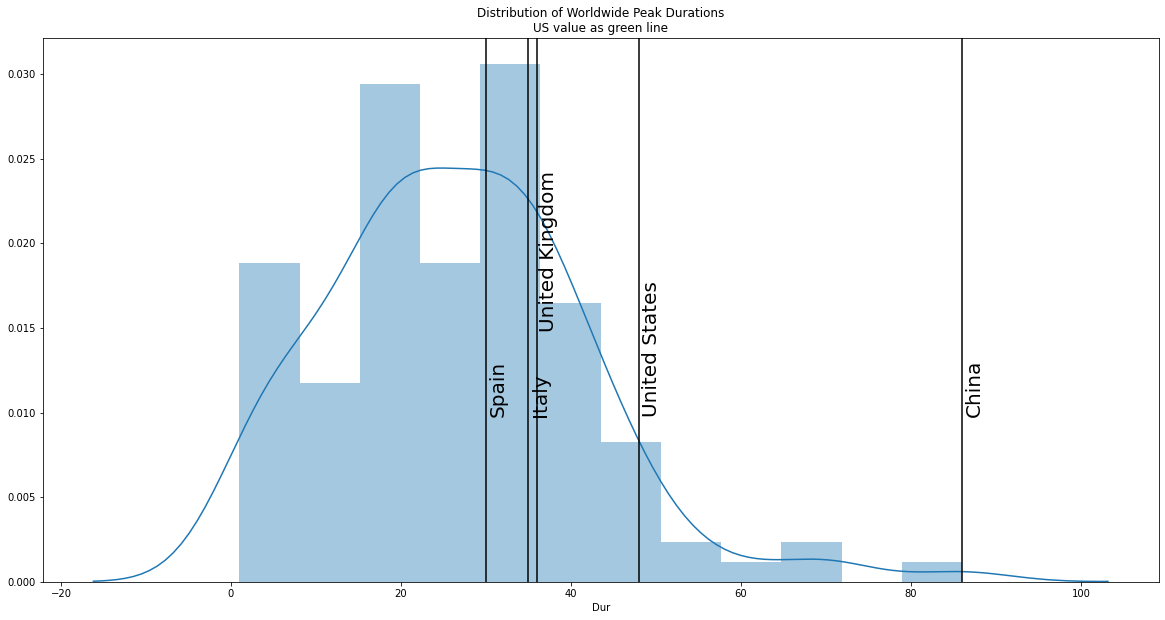

In [14]:
plt.figure(figsize=(20,10))
sns.distplot(duration_df['Dur'], hist=True)
plt.title("Distribution of Worldwide Peak Durations\nUS value as green line")
plt.axvline(x=duration_df[duration_df.index == 'US']['Dur'][0], c='k')
plt.text(duration_df[duration_df.index == 'US']['Dur'][0]+0.30,0.01,'United States',rotation=90, size=20)
plt.axvline(x=duration_df[duration_df.index == 'IT']['Dur'][0], c='k')
plt.text(duration_df[duration_df.index == 'IT']['Dur'][0]+0.30,0.01,'Italy',rotation=90, size=20)
plt.axvline(x=duration_df[duration_df.index == 'CN']['Dur'][0], c='k')
plt.text(duration_df[duration_df.index == 'CN']['Dur'][0]+0.30,0.01,'China',rotation=90, size=20)
plt.axvline(x=duration_df[duration_df.index == 'ES']['Dur'][0], c='k')
plt.text(duration_df[duration_df.index == 'ES']['Dur'][0]+0.30,0.01,'Spain',rotation=90, size=20)
plt.axvline(x=duration_df[duration_df.index == 'GB']['Dur'][0], c='k')
plt.text(duration_df[duration_df.index == 'GB']['Dur'][0]+0.30,0.015,'United Kingdom',rotation=90, size=20)
plt.show()

In [15]:
# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    # Distributions to check
    #skipping st.levy_stable as it is very slow to fit 
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    for distribution in DISTRIBUTIONS:
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                params = distribution.fit(data)
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse
                print(distribution.name, sse)
        except Exception:
            pass

    return (best_distribution.name, best_params)


In [16]:
best_distribution_name, best_params = best_fit_distribution(duration_df['Dur'])
best_distribution_name, best_params

alpha 0.1714375084972883
anglit 0.11004537427632369
arcsine 0.1300905827909367
beta 0.09985853446188293
betaprime 0.09954356387113157
bradford 0.10898857592393829
burr 0.09817893698346675
cauchy 0.10340886519746734
chi 0.29256981018156286
chi2 0.4798884770157217
cosine 0.10502724241848813
dgamma 0.09653085323391279
dweibull 0.09638858946769802
erlang 0.0995764684333795
expon 0.11159219443108506
exponnorm 0.09907605560988375
exponweib 0.26680331719292305
exponpow 0.2594857967978715
f 0.09957229845545029
fatiguelife 0.09945171299676414
fisk 0.09951996106573849
foldcauchy 0.10065904148509727
foldnorm 0.09786914809781629
frechet_r 0.35312123076006635
frechet_l 0.2792294962993745
genlogistic 0.09971429435648661
genpareto 0.10520465814189478
gennorm 0.09891029818945442
genexpon 0.1004255649030871
genextreme 0.09955901285642753
gausshyper 0.09985854585704021
gamma 0.09957646704204778
gengamma 0.09961932791953321
genhalflogistic 0.1012954208391374
gilbrat 0.11050236514798573
gompertz 0.2700390

('dweibull', (1.3507210103823493, 26.420862759184544, 13.056099766245001))

Double Gamma Fitted Parameters --> (1.3507210103823493, 26.420862759184544, 13.056099766245001)


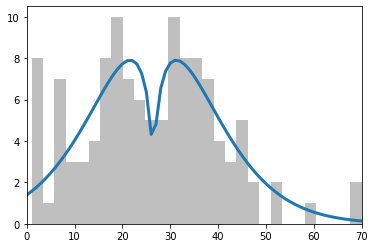

In [17]:
from scipy.stats import norm
from numpy import linspace
from pylab import plot,show,hist,figure,title

y = duration_df['Dur']
x = np.arange(len(y))
param = st.dweibull.fit(y)
print("Double Gamma Fitted Parameters -->", param)
number_of_bins = 30
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)

# Create the plot
h = plt.hist(y, bins = bin_cutoffs, color='0.75')
pdf_fitted = st.dweibull.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
pdf_fitted *= scale_pdf

# Add the line to the plot
plt.plot(pdf_fitted, linewidth=3)

# Set the plot x axis to contain 99% of the data
# This can be removed, but sometimes outlier data makes the plot less clear
plt.xlim(0,np.percentile(y,99))
plt.show()

### The above is an interesting finding ...
    - It appears that the global pandemic appears to be a mix of two different distributions
    - Hypothesis 1: China (and far east one, followed by the Western Europe / US?
    - Hypothesis 2: Two different strains, each dominating in one set of countries? 
    - Additional distributions may superimpose as more data over time is collected
    - I would conclude that the duration to peak death rate should be modeled by a mixture of distributions 

### Logistic Fit to the Cumulative Death Curves
    China, South Korea, ...

In [18]:
#https://medium.com/@santiagocasas/using-python-scientific-tools-for-a-rough-analysis-of-covid-19-data-d3ac58f474bf
#https://glowingpython.blogspot.com/2012/07/distribution-fitting-with-scipy.html
#https://ipython-books.github.io/75-fitting-a-probability-distribution-to-data-with-the-maximum-likelihood-method/
#https://pythonhealthcare.org/2018/05/03/81-distribution-fitting-to-data/
#https://ipython-books.github.io/93-fitting-a-function-to-data-with-nonlinear-least-squares/
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.dweibull.html#scipy.stats.dweibull

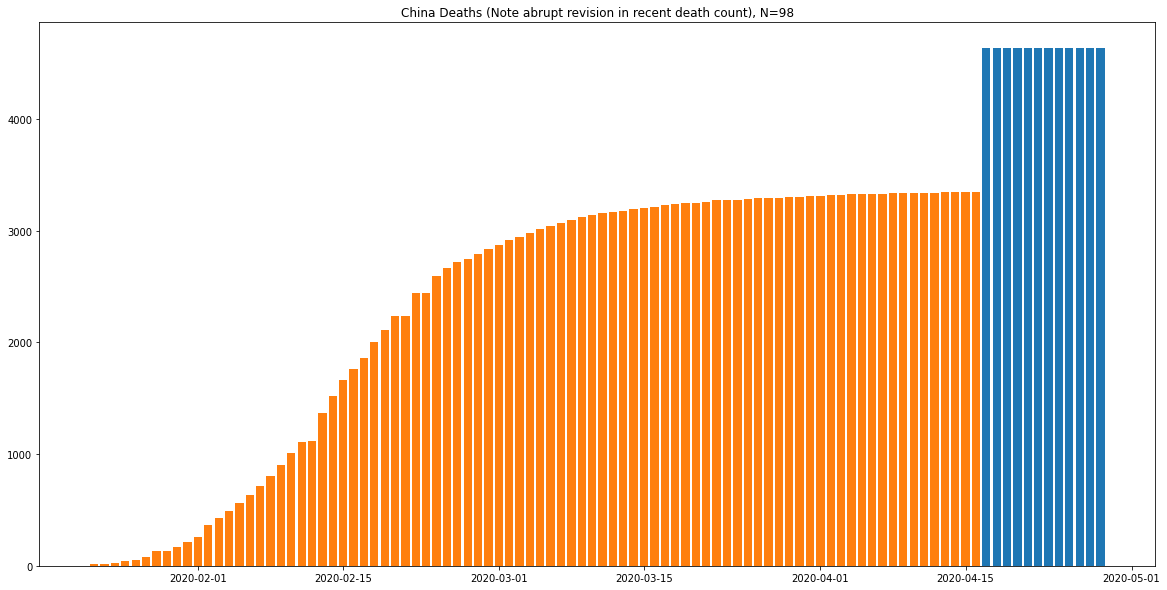

In [18]:
#TODO Fix the arbitrary update to the mortality counts, for now simply truncate data to continue 

cn_deaths_df_grouped = cov19_raw_df.loc[ (cov19_raw_df['Case_Type'] == 'Deaths') & (cov19_raw_df['iso2'] == 'CN') ][['Date','Cases']].groupby('Date').sum()
cn_deaths_truncated = cn_deaths_df_grouped.drop(cn_deaths_df_grouped.tail(12).index,inplace=False)
plt.figure(figsize=(20,10))
plt.bar(cn_deaths_df_grouped.index, cn_deaths_df_grouped['Cases']) 
plt.bar(cn_deaths_truncated.index, cn_deaths_truncated['Cases']) 
plt.title("China Deaths (Note abrupt revision in recent death count), N="+str(len(cn_deaths_df_grouped.index)))
plt.show()



Best fit a,b,c --> 6.671372984201263 24.56002916097674 3284.7708332455823


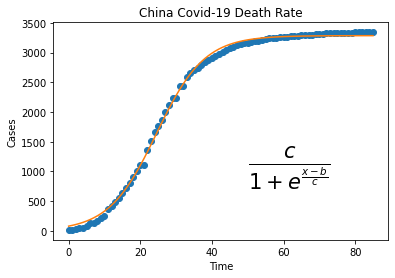

In [19]:
import scipy.optimize as opt
from scipy.optimize import fsolve

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def gompertz_model(x,a,b,c):
    return c*np.exp(-b*np.exp(-x/a))

f = logistic_model
a, b, c = 0,0,0

y = cn_deaths_truncated.Cases
x = np.arange(len(y))
#x = cn_deaths_truncated.index

(a_, b_, c_), _ = opt.curve_fit(f, x, y)
print("Best fit a,b,c -->", a_,b_,c_)
y_fit = f(x, a_, b_, c_)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y, 'o')
ax.plot(x, y_fit, '-')
plt.title("China Covid-19 Death Rate")
plt.text(50,1000, r'$\frac{c}{1 + e^{\frac{x-b}{c}}}$', size=30)
plt.xlabel('Time')
plt.ylabel('Cases')
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
MSLE=mean_squared_log_error(y,y_fit)
print("Mean squared log error (MSLE): ", '{:.3f}'.format(MSLE))
print("R2 score: ", '{:.3f}'.format(r2_score(y,y_fit)))

perc_flat = 0.98
sol = int(fsolve(lambda x : f(x,a_,b_,c_) - perc_flat*int(c_), b_))
print('Day of flattening of the infection curve', sol)

Mean squared log error (MSLE):  0.117
R2 score:  0.998
Day of flattening of the infection curve 50


Best fit a,b,c --> 10.632682496579266 43.214967898455406 255.0386754396921


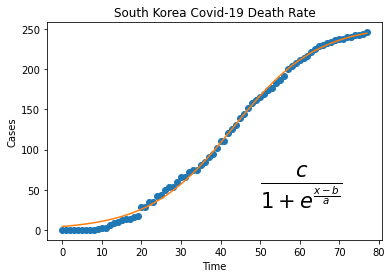

In [21]:
kr_deaths_df_grouped = cov19_raw_df.loc[ (cov19_raw_df['Case_Type'] == 'Deaths') & (cov19_raw_df['iso2'] == 'KR') ][['Date','Cases']].groupby('Date').sum()

f = logistic_model
a, b, c = 0,0,0

y = kr_deaths_df_grouped.Cases[20:]
x = np.arange(len(y))

(a_, b_, c_), _ = opt.curve_fit(f, x, y)
print("Best fit a,b,c -->", a_,b_,c_)
y_fit = f(x, a_, b_, c_)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y, 'o')
ax.plot(x, y_fit, '-')
plt.title("South Korea Covid-19 Death Rate")
plt.text(50,50, r'$\frac{c}{1 + e^{\frac{x-b}{a}}}$', size=30)
plt.xlabel('Time')
plt.ylabel('Cases')
plt.show()

### Epidemiological modeling -- SIR Model 
  - https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-contact-number
  - https://www.sciencedirect.com/science/article/pii/S2468042719300491
  - https://loe.org/images/content/091023/Zombie%20Publication.pdf

### Simple SIR Model for Epidemics

\begin{align*}
\frac{ds}{dt} = -b \> s(t) \> i(t)
\end{align*}

\begin{align*}
\frac{dr}{dt} = k \> i(t)
\end{align*}

\begin{align*}
Since, \> \frac{ds}{dt} + \frac{di}{dt} + \frac{dr}{dt} = 0
\end{align*}

\begin{align*}
\frac{di}{dt} = b \> s(t) \> i(t) - k  \> i(t)
\end{align*}

 - s indicates fraction of population susceptible
 - i indicates fraction of population infected
 - k indicates fraction of population recovered or inoculated 
 - b, k are parameters

In [22]:
# solve the system dy/dt = f(y, t)
def f(y, t):
    Si = y[0]
    Ii = y[1]
    Ri = y[2]
    # the model equations (see Munz et al. 2009)
    f0 = -b*Si*Ii
    f1 = b*Si*Ii - k*Ii
    f2 = k*Ii
    return [f0, f1, f2]

def solve_SIR(S0,I0,R0,b,k,tmax):
    '''
        S0   --> Initial fraction of susceptible population
        I0   --> Initial fraction of infected population 
        R0   --> Initial fraction of recovered / inoculated population
        k    --> Fixed fraction k of the infected group that will recover during any given day, transmission rate / d
        b    --> fixed number of contacts per day encountered by each infected individual, recovered percent / d 
        tmax --> time steps to run the simulation 
    '''
    y0 = [S0, I0, R0]     # initial condition vector
    t  = np.linspace(0, tmax, tmax)         # time grid
    soln = odeint(f, y0, t)
    S = soln[:, 0]
    I = soln[:, 1]
    R = soln[:, 2]
    return t,S,I,R

In [23]:
def plot_t_s_i_r(t, S, I, R, b, k, axis):
    axis.plot(t, S, label='Susceptible')
    axis.plot(t, I, label='Infectious')
    axis.plot(t, R, label='Recovered')
    axis.set_title('SIR Model Sensitivity (b,k) -->(' + str(b) + ',' + str(k) + ')')
    axis.legend(loc=0)
    
def show_model_and_mortality(y, t, I, country, data_cumulative_mortalities):
    #y = cn_deaths_truncated['Cases'].diff()[1:]
    x = np.arange(len(y))
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.bar(x,y, label="Deaths")
    ax2.plot(t, I, label='Infectious',c="r",linewidth=3)
    plt.title(country + " daily deaths and SIR Infectious Ratio\nTotal Observed Mortality=" + 
              str(data_cumulative_mortalities[0]) + "\nTotal Modeled Mortality=" + str(data_cumulative_mortalities[1]))
    plt.legend(loc=0)
    plt.show()
    
#Assumes simply -- a constant proportion of infected people die daily 
#so we align the model peak with the data peak and take the ratio to compute modeled deaths per day 
def get_cumulative_mortality(data,I):
    modeled_max_index = np.where(I == np.amax(I))
    data_max_index = np.where(data == np.amax(data))
    modeled_daily_deaths = np.round(I * (np.amax(data)/np.amax(I)))
    return np.sum(data), np.sum(modeled_daily_deaths)

### Understanding the parameters via a Sensitivity Analysis

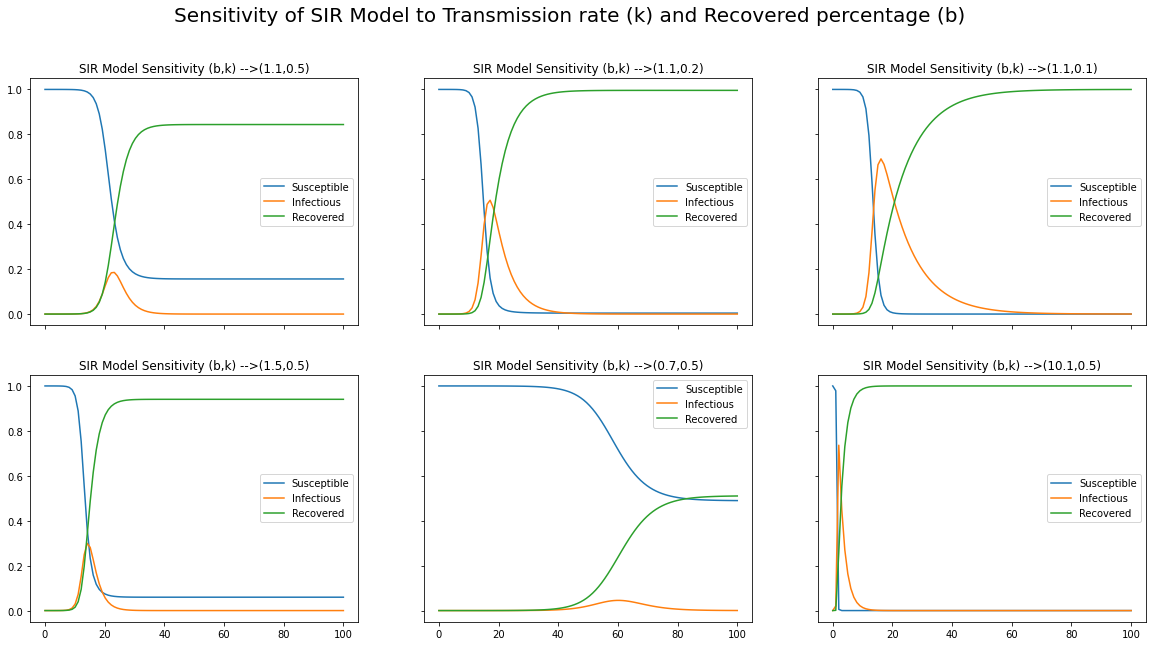

In [24]:
from scipy.integrate import odeint
plt.ion()
plt.rcParams['figure.figsize'] = 20, 10
parms = []
#sensitivity to k
parms += [(1.1,1./2),(1.1,1./5),(1.1,1./10)]
#sensitivity to b
parms += [(1.5,1./2),(0.7,1./2),(10.1,1./2)]

rows, cols = int(len(parms)/3),3 

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
fig.suptitle('Sensitivity of SIR Model to Transmission rate (k) and Recovered percentage (b)', size=20)
for r in range(rows):
    for c in range(cols):
        b,k = parms[r*cols + c]
        t,S,I,R = solve_SIR(1., 1.27E-06, 0, b, k, 100)
        plot_t_s_i_r(t,S,I,R,b,k,axes[r][c])

plt.show()


### Modeling China Daily Mortality

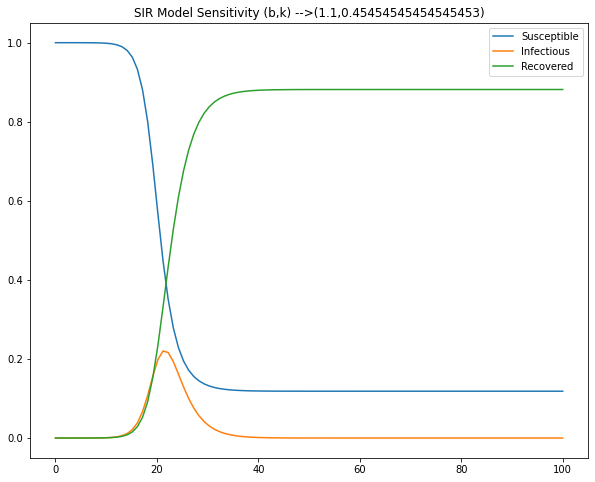

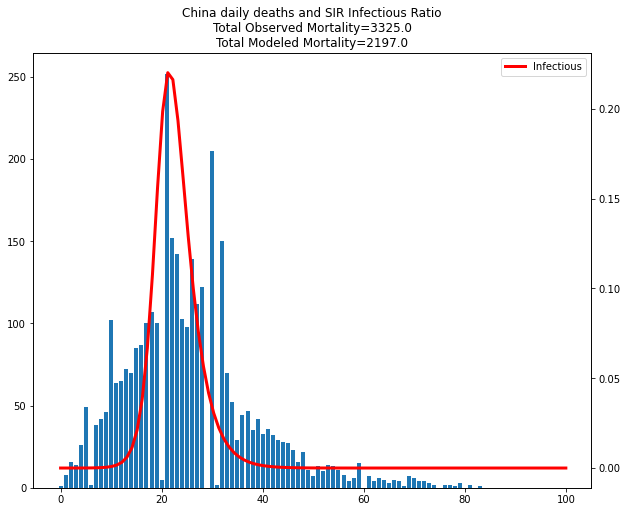

In [25]:
from scipy.integrate import odeint
plt.ion()
plt.rcParams['figure.figsize'] = 10, 8
b,k = (1.1,1./2.2)
t,S,I,R = solve_SIR(1., 1.27E-06, 0, b, k, 100)

data = cn_deaths_truncated['Cases'].diff()[1:]
data_cumulative_mortalities = get_cumulative_mortality(data, I)

fig, ax = plt.subplots()
plot_t_s_i_r(t,S,I,R,b,k,ax)

show_model_and_mortality(data, t, I, "China", data_cumulative_mortalities)

### Modeling United States Daily Mortality

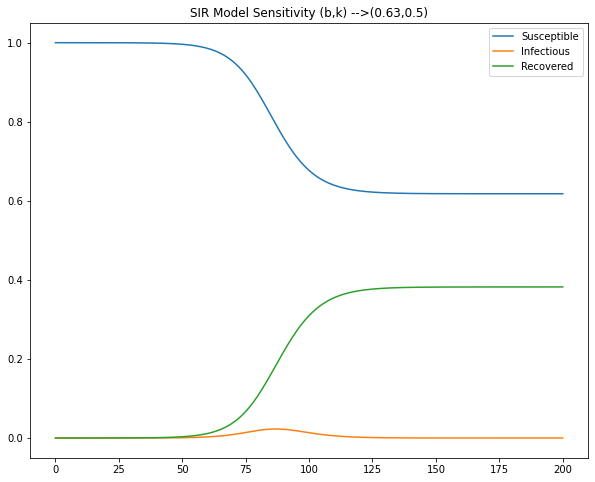

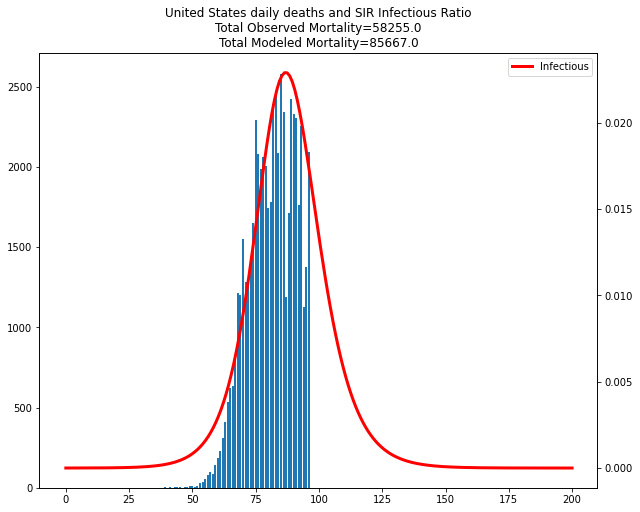

In [26]:
from scipy.integrate import odeint
plt.ion()
plt.rcParams['figure.figsize'] = 10, 8
b,k = (0.63, 1./2)
t,S,I,R = solve_SIR(1., 1.27E-06, 0, b, k, 200)

data = us_deaths_df_grouped['Cases'].diff()[1:]
data_cumulative_mortalities = get_cumulative_mortality(data, I)

fig, ax = plt.subplots()
plot_t_s_i_r(t,S,I,R,b,k,ax)

show_model_and_mortality(data, t, I, "United States", data_cumulative_mortalities)


### Modeling Italy Daily Mortality

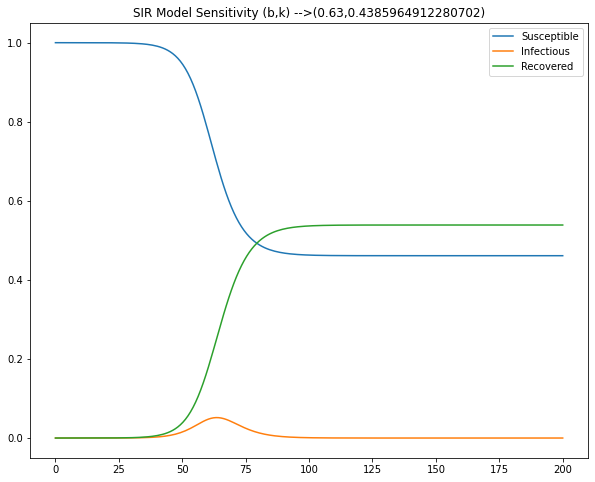

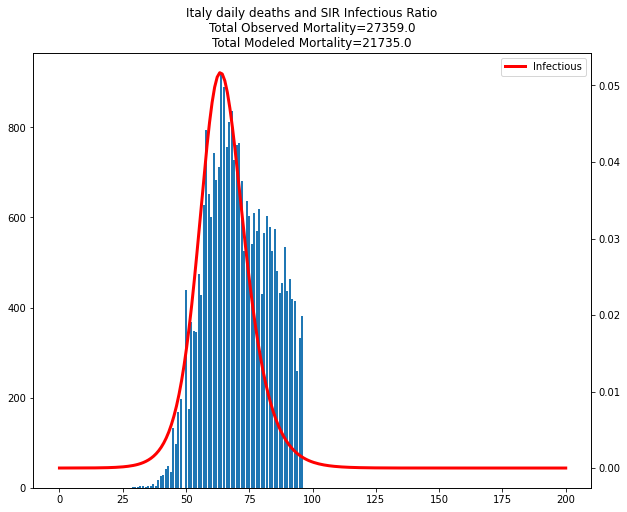

In [27]:
from scipy.integrate import odeint
plt.ion()
plt.rcParams['figure.figsize'] = 10, 8
b,k = (0.63, 1./2.28)
t,S,I,R = solve_SIR(1., 1.27E-06, 0, b, k, 200)

data = it_deaths_df_grouped['Cases'].diff()[1:]
data_cumulative_mortalities = get_cumulative_mortality(data, I)

fig, ax = plt.subplots()
plot_t_s_i_r(t,S,I,R,b,k,ax)

show_model_and_mortality(data, t, I, "Italy", data_cumulative_mortalities)


### Flattening the Curve (Impact of Interventions)
    - Extreme Isolation
    - Social Distancing
    - Vaccinations
    - Inoculations

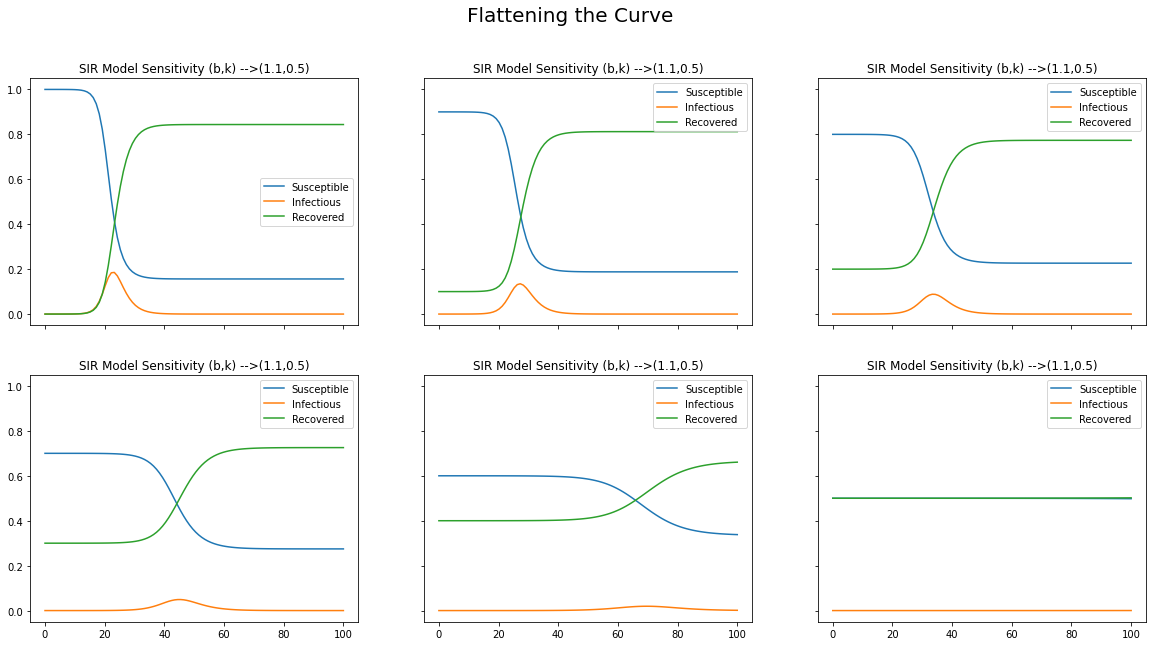

In [28]:
from scipy.integrate import odeint
plt.ion()
plt.rcParams['figure.figsize'] = 20, 10

parms = [(1.1,1./2)]*6
susceptible_ratios = [(1,0),(0.9,0.1),(.8,0.2),(0.7,0.3),(.6,.4),(0.5,0.5)]
rows, cols = int(len(parms)/3),3 

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
fig.suptitle('Flattening the Curve', size=20)
for r in range(rows):
    for c in range(cols):
        b,k = parms[r*cols + c]
        t,S,I,R = solve_SIR(susceptible_ratios[r*cols + c][0], 1.27E-06, susceptible_ratios[r*cols + c][1], b, k, 100)
        plot_t_s_i_r(t,S,I,R,b,k,axes[r][c])

plt.show()

### Back to Bayes!

In [29]:
#https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

In [30]:
us_deaths_df_grouped = cov19_raw_df.loc[ (cov19_raw_df['Case_Type'] == 'Deaths') & (cov19_raw_df['iso2'] == 'US') ][['Date','Cases']].groupby('Date').sum()
us_cases_df_grouped = cov19_raw_df.loc[ (cov19_raw_df['Case_Type'] == 'Confirmed') & (cov19_raw_df['iso2'] == 'US') ][['Date','Cases']].groupby('Date').sum()


In [31]:
us_cases_df_grouped.head()

,Cases
Date,
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5


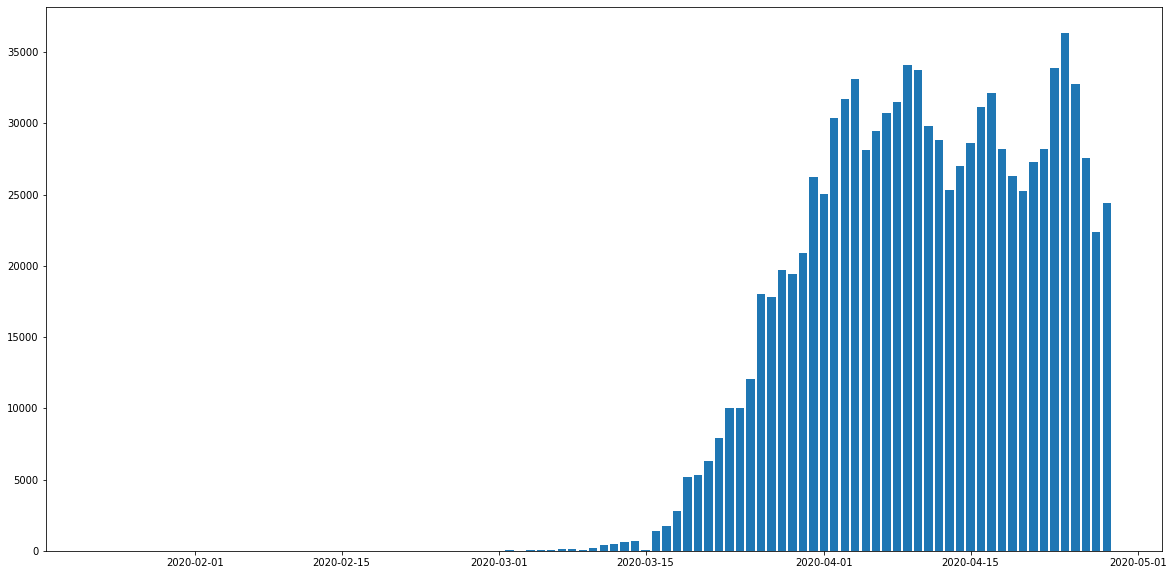

In [32]:
plt.figure(figsize=(20,10))
#plt.bar(us_deaths_df_grouped.index, us_deaths_df_grouped['Cases']) 
plt.bar(us_cases_df_grouped.index, us_cases_df_grouped['Cases'].diff()) 
plt.show()

In [33]:
#verify pystan installation
#python -c "import pystan; model_code = 'parameters {real y;} model {y ~ normal(0,1);}'; model = pystan.StanModel(model_code=model_code); y = model.sampling().extract()['y']; print(y.mean())"

### Deterministic SIR Model for Epidemics

\begin{align*}
Y_{t} \sim Poisson(\> \lambda_{t} \>)
\end{align*}

\begin{align*}
\int_0^t \! (\> \beta \> \frac{I(s)}{N} \> S(s) - \gamma \> I(s) \>) \> \mathrm{d}s
\end{align*}

    with priors:

\begin{align*}
\beta \sim Lognormal(0,1)
\end{align*}

\begin{align*}
\gamma \sim \Gamma(0.004,0.002)
\end{align*}

\begin{align*}
s(0) \sim \beta(0.5,0.5)
\end{align*}

    with:
$Y_{t}$ are the daily infection counts $$\>$$
$s(0)$ is the initial proportion of susceptible individuals $$\>$$
$i(0) = 1 - s(0)$  $$\>$$

In [34]:
deterministic_SIR_model_code = """
    functions {
      real[] SIR(real t,  // time
                real[] y,           // system state {susceptible,infected,recovered}
                real[] theta,       // parameters
                real[] x_r,
                int[] x_i) {
  
                  real dy_dt[3];
  
                  dy_dt[1] = - theta[1] * y[1] * y[2];
                  dy_dt[2] = theta[1] * y[1] * y[2] - theta[2] * y[2];
                  dy_dt[3] = theta[2] * y[2];
  
                  return dy_dt;
                }
  
  }
  data {
      int<lower = 1> n_obs;       // number of days observed
      int<lower = 1> n_theta;     // number of model parameters
      int<lower = 1> n_difeq;     // number of differential equations
      int<lower = 1> n_pop;       // population 
      int y[n_obs];           // data, total number of infected individuals each day
      real t0;                // initial time point (zero)
      real ts[n_obs];         // time points observed
  }
  
  transformed data {
      real x_r[0];
      int x_i[0];
  }
  
  parameters {
      real<lower = 0> theta[n_theta]; // model parameters {beta,gamma}
      real<lower = 0, upper = 1> S0;  // initial fraction of susceptible individuals
  }
  
  transformed parameters{
      real y_hat[n_obs, n_difeq]; // solution from the ODE solver
      real y_init[n_difeq];     // initial conditions for both fractions of S and I
  
      y_init[1] = S0;
      y_init[2] = 1 - S0;
      y_init[3] = 0;
      y_hat = integrate_ode_rk45(SIR, y_init, t0, ts, theta, x_r, x_i);
  
  }
  
  model {
      real lambda[n_obs];      //poisson parameter

      //priors
      theta[1] ~ lognormal(0,1);
      theta[2] ~ gamma(0.004,0.02);  //Assume mean infectious period = 5 days 
      S0 ~ beta(0.5, 0.5);

      //likelihood
      for (i in 1:n_obs){
          lambda[i] = y_hat[i,2]*n_pop;
      }
      y ~ poisson(lambda);
  }
  
  generated quantities {
      real R_0;      // Basic reproduction number
      R_0 = theta[1]/theta[2];
  }
    """

sm = pystan.StanModel(model_code=deterministic_SIR_model_code)
sm

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_058fd86095a1f5774c5e182a239e24d3 NOW.


In [77]:
us_dates = np.array(us_cases_df_grouped.index[1:].to_pydatetime(), dtype=np.datetime64)
us_cases = us_cases_df_grouped['Cases'].diff()[1:].astype(int).to_numpy()

N = len( us_dates ) # Number of days observed throughout the outbreak
pop = np.int(ref_df[ref_df.index == 'US']['Population'])

sample_time = list(range(1,N+1))
us_data = {'n_obs': N , 'n_theta': 2, 'n_difeq': 3, 'n_pop': pop , 'y': us_cases , 't0': 0, 'ts': sample_time }
# Specify parameters to monitor
parameters = ["y_hat", "y_init", "theta" , "R_0"]

n_chains = 1
n_warmups = 1000
n_iter = 201000
n_thin = 50
random.seed(1234)
np.random.seed(1234)
control = {'adapt_delta': 0.80}       #default = 0.80

def init_funct():
    return {'theta': [np.random.uniform(0,2,1)[0], np.random.uniform(0,0.4,1)[0]], 
            'S0': np.random.uniform( (pop-3)/pop, (pop-1)/pop, 1)[0]}


#python crash errors 
#defaults write com.apple.CrashReporter UseUNC 1
#defaults write com.apple.CrashReporter DialogType none

In [78]:
nuts_fit_us = sm.sampling(data = us_data, pars = parameters, control = control, init = init_funct, 
                          chains = n_chains, warmup = n_warmups, iter = n_iter, thin=n_thin, seed=1234)


In [79]:
us_output = nuts_fit_us.extract(permuted=True)
us_output.keys()
print(nuts_fit_us)

Inference for Stan model: anon_model_058fd86095a1f5774c5e182a239e24d3.
1 chains, each with iter=201000; warmup=1000; thin=50; 
post-warmup draws per chain=4000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%     25%     50%     75%  97.5%  n_eff   Rhat
y_hat[1,1]     1.0  5.5e-7 8.8e-7    1.0     1.0     1.0     1.0    1.0      3   2.45
y_hat[2,1]     1.0  1.0e-6 1.6e-6    1.0     1.0     1.0     1.0    1.0      3   2.47
y_hat[3,1]     1.0  1.5e-6 2.4e-6    1.0     1.0     1.0     1.0    1.0      3   2.48
y_hat[4,1]     1.0  2.0e-6 3.2e-6    1.0     1.0     1.0     1.0    1.0      3   2.48
y_hat[5,1]     1.0  2.6e-6 4.1e-6    1.0     1.0     1.0     1.0    1.0      3   2.49
y_hat[6,1]     1.0  3.1e-6 5.0e-6    1.0     1.0     1.0     1.0    1.0      3   2.49
y_hat[7,1]     1.0  3.7e-6 6.0e-6    1.0     1.0     1.0     1.0    1.0      3    2.5
y_hat[8,1]     1.0  4.4e-6 7.0e-6    1.0     1.0     1.0     1.0    1.0      3    2.5
y_hat[9,1]     1.0  5.1e-6 8.1e-6 

In [80]:
np.shape(us_output['y_hat'])

(4000, 97, 3)

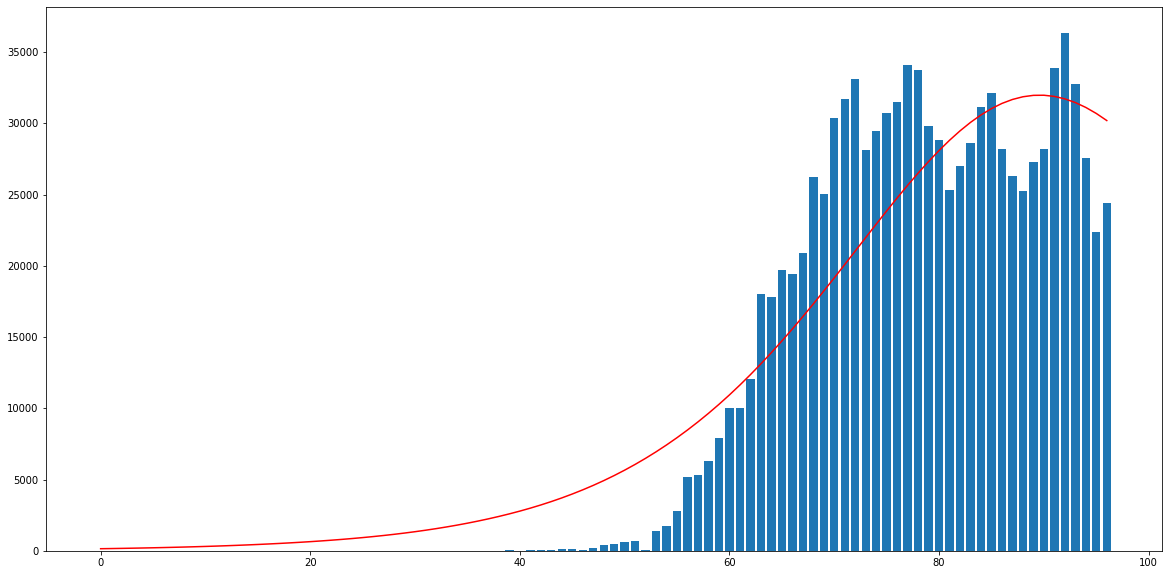

In [81]:
us_simulated_means = np.mean(nuts_fit_us['y_hat'],axis=0)
plt.plot(np.arange(np.shape(us_simulated_means)[0]), us_simulated_means[:,1]*pop,'r')
plt.bar(np.arange(np.shape(us_simulated_means)[0]), us_cases) 
plt.show()

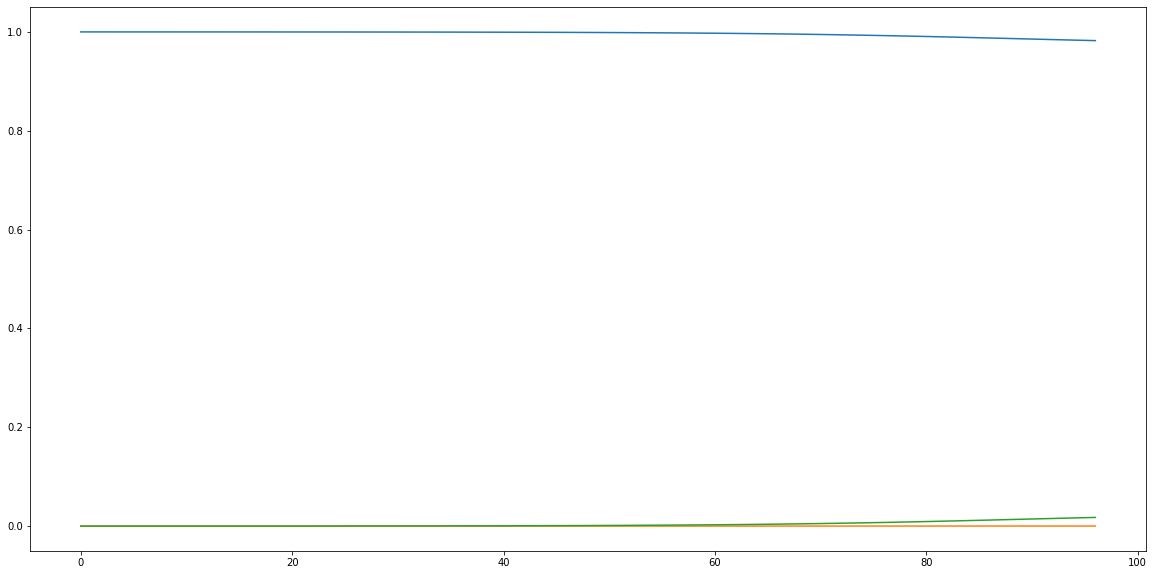

In [82]:
plt.plot(np.arange(np.shape(us_simulated_means)[0]), us_simulated_means)
plt.show()

In [83]:
us_cumulative_mortalities = get_cumulative_mortality(us_deaths_df_grouped['Cases'].diff()[1:], 
                                                     us_simulated_means[:,1]*pop)

print("Total Observed Deaths -->", int(us_cumulative_mortalities[0]))
print("Total Modeled Deaths -->", int(us_cumulative_mortalities[1]))

Total Observed Deaths --> 58255
Total Modeled Deaths --> 85049


In [ ]:
variational_fit_us

In [41]:
#https://arxiv.org/pdf/1903.00423.pdf

#influenza_england_1978_school_df = pd.read_csv("influenza_england_1978_school.csv")
#influenza_england_1978_school_df.head()

In [42]:
#onset = influenza_england_1978_school_df['date']
#cases = influenza_england_1978_school_df['in_bed']
#N = len( onset ) # Number of days observed throughout the outbreak
#pop = 763 # Population
#sample_time = list(range(1,N+1))
#flu_data = {'n_obs': N , 'n_theta': 2, 'n_difeq': 3, 'n_pop': pop , 'y': cases , 't0': 0, 'ts': sample_time }
# Specify parameters to monitor
#parameters = ["y_hat", "y_init", "theta" , "R_0"]

#n_chains = 5
#n_warmups = 500
#n_iter = 100500
#n_thin = 50
#random.seed(1234)
#np.random.seed(1234)

#def init_funct():
#    return {'theta': [np.random.uniform(0,5,1)[0], np.random.uniform(0.2,0.4,1)[0]], 
#            'S0': np.random.uniform( (pop-3)/pop, (pop-1)/pop, 1)[0]}


In [43]:
#nuts_fit_1 = sm.sampling(data = flu_data, pars = parameters, init = init_funct,  
#                      chains = n_chains, warmup = n_warmups, iter = n_iter, thin=n_thin, seed=13219)


In [44]:
#output = nuts_fit_1.extract(permuted=True)
#print(output.keys())
#print(print(nuts_fit_1))

In [45]:
#plt.plot(output['y_hat'])

#np.shape(output['y_hat'])
#simulated_means = np.mean(output['y_hat'],axis=0)
#plt.plot(np.arange(np.shape(simulated_means)[0]), simulated_means)
#plt.show()

In [46]:
#plt.plot(np.arange(np.shape(simulated_means)[0]), simulated_means[:,1]*pop,'r')
#plt.bar(np.arange(np.shape(simulated_means)[0]), cases) 
#plt.show()

In [47]:
#cases